In [1]:
import os
import pandas as pd
import numpy as np
import time, gc
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pretrainedmodels
from argparse import Namespace
from sklearn.utils import shuffle
from apex import amp
from sklearn.model_selection import StratifiedKFold
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import albumentations as albu
import PIL

In [2]:
DATA_DIR = '/mnt/chicm/data/bengali'
train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
test_df = pd.read_csv(f'{DATA_DIR}/test.csv')
class_map_df = pd.read_csv(f'{DATA_DIR}/class_map.csv')
sample_sub_df = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

In [4]:
!ls $DATA_DIR/ekush

ekush_dataset.zip  ekush_image_data.feather  ekush_train.csv


In [5]:
df = pd.read_feather(f'{DATA_DIR}/ekush/ekush_image_data.feather')
df.head()

,image_id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel32322,pixel32323,pixel32324,pixel32325,pixel32326,pixel32327,pixel32328,pixel32329,pixel32330,pixel32331
0,male/0_BAR_14_1_356.jpg,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,male/0_BAR_11_1_12.jpg,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,254,254,255,255
2,male/0_BAR_14_1_358.jpg,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,male/0_BAR_12_1_1210.jpg,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,male/0_BAR_14_1_357.jpg,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [19]:
df.shape

(306461, 32333)

In [20]:
df_train = pd.read_csv(f'{DATA_DIR}/ekush/ekush_train.csv')

In [21]:
df_train.head()

,image_id,grapheme
0,male/0_BAR_14_1_356.jpg,া
1,male/0_BAR_11_1_12.jpg,া
2,male/0_BAR_14_1_358.jpg,া
3,male/0_BAR_12_1_1210.jpg,া
4,male/0_BAR_14_1_357.jpg,া


In [22]:
df_train.shape

(306461, 2)

In [6]:
HEIGHT = 137
WIDTH = 236

def get_img(img_idx):
    return 255 - df.iloc[img_idx].values[1:].reshape(HEIGHT, WIDTH).astype(np.uint8)
    #return df.iloc[img_idx].values[1:].reshape(HEIGHT, WIDTH).astype(np.uint8)

In [7]:
def get_imgs(n=8):
    return [get_img(i) for i in range(n)]    

In [8]:
def get_img_tensor(img_idx):
    img = get_img(img_idx)
    return transforms.functional.to_tensor(img)

In [9]:
def get_img_batch(batch_size=8):
    imgs = []
    for i in range(batch_size):
        imgs.append(get_img_tensor(i))
    return torch.stack(imgs, 0)

In [10]:
def show_imgs(imgs, titles=None):
    n = len(imgs)
    plt.figure(figsize=(30, 20))
    columns = 4
    for i, img in enumerate(imgs):
        plt.subplot(n / columns + 1, columns, i + 1)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(img)

In [11]:
def show_img_batch(img):
    show_imgs([transforms.functional.to_pil_image(img[i]) for i in range(len(img))])

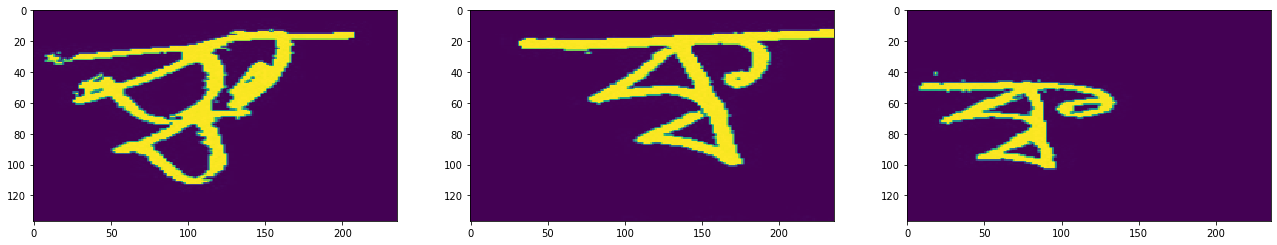

In [15]:
show_imgs([get_img(0), get_img(1), get_img(2)])

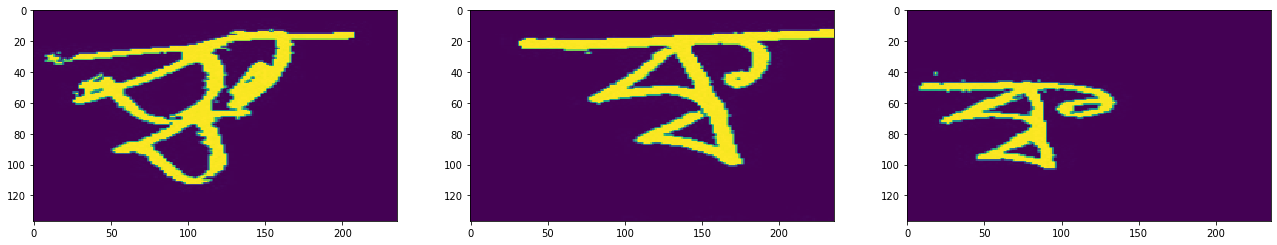

In [16]:
show_imgs([get_img(0), get_img(1), get_img(2)])

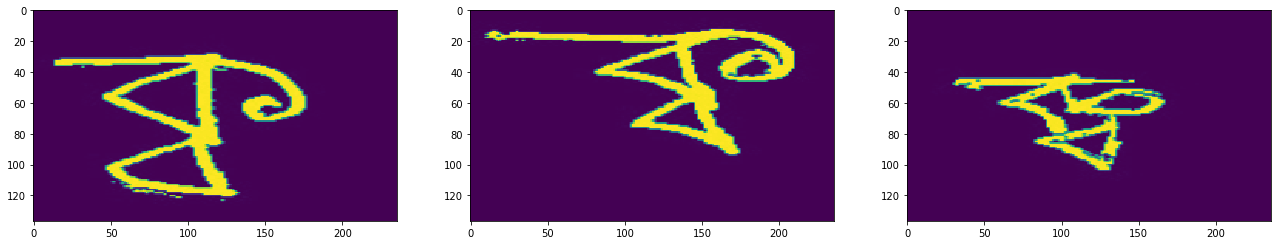

In [18]:
show_imgs([get_img(4), get_img(5), get_img(6)])